# Background information
*   This notebooks contains the data analytic pipeline for the manuscript titled "Understanding Policing: A Quantitative Analysis" and submitted to *Perspectives on Behavior Science*.
*   Data for this notebook can be obtained from the Stanford Police Project: https://openpolicing.stanford.edu/data/. 

In [1]:
# Packages!!
import os
import sys
import pandas as pd
import numpy as np
import scipy
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Upload data 
from google.colab import drive
drive.mount('/content/gdrive')
%cd './gdrive/MyDrive/Policing Data/Pittsburgh/Data'
raw_data = pd.read_csv("pa_pittsburgh_2020_04_01.csv")
data = raw_data.copy()

Mounted at /content/gdrive
/content/gdrive/MyDrive/Policing Data/Pittsburgh/Data


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,6,12,13,15,16,17,18,20,21,23,24,25,27,28,29,30,31,32,33,34) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Sample of what the data looks like and the data types
data.head()

,raw_row_number,date,time,location,lat,lng,neighborhood,subject_age,subject_race,subject_sex,officer_id_hash,officer_age,officer_race,officer_sex,type,violation,arrest_made,citation_issued,warning_issued,outcome,contraband_found,frisk_performed,search_conducted,reason_for_stop,raw_zone,raw_object_searched,raw_race,raw_ethnicity,raw_zone_division,raw_evidence_found,raw_weapons_found,raw_nothing_found,raw_police_zone,raw_officer_race,raw_officer_zone
0,1,2008-01-01,00:14:00,351 S Negley Ave,40.459466,-79.932802,NaN,20.0,white,male,3bb3b1bd48,41.0,NaN,NaN,pedestrian,NaN,False,False,False,NaN,NaN,NaN,False,Other,NaN,NaN,White,White,-,NaN,NaN,NaN,NaN,NaN,NaN
1,3,2008-01-01,00:14:00,376 Main St,40.465868,-79.955594,NaN,19.0,white,male,3bb3b1bd48,41.0,NaN,NaN,pedestrian,NaN,False,False,False,NaN,NaN,NaN,False,Other,NaN,NaN,White,White,-,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2008-01-01,00:14:00,Stamair Way & Baum Blvd,40.456812,-79.939041,NaN,16.0,white,male,3bb3b1bd48,41.0,NaN,NaN,pedestrian,NaN,False,False,False,NaN,NaN,NaN,False,Other,-,NaN,White,White,-,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2008-01-01,01:59:00,N Braddock Ave & Thomas Blvd,40.448873,-79.893923,NaN,21.0,NaN,male,b62aedb5bb,29.0,NaN,NaN,pedestrian,NaN,True,False,False,arrest,NaN,NaN,True,majorCrimes Other,-,person,Black,White,-,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2008-01-01,14:50:00,2518 West Liberty Ave,40.398780,-80.026439,NaN,41.0,white,male,1ccb6bd45a,NaN,NaN,NaN,pedestrian,NaN,False,False,False,NaN,NaN,NaN,True,narcVice,-,person vehicle place,White,NaN,N/V,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Create year and month cols for grouping
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month

# Distributions of stops and putative reinforcers per month for all officers

In [5]:
# Create individual data frames for the different independent and dependent variables
offcr_stops = data.groupby(['year', 'month', 'officer_id_hash']).size()
offcr_cites = data.groupby(['year', 'month', 'officer_id_hash', 'citation_issued']).size()
offcr_search = data.groupby(['year', 'month', 'officer_id_hash', 'search_conducted']).size()
offcr_frisk = data.groupby(['year', 'month', 'officer_id_hash', 'frisk_performed']).size()
offcr_contra = data.groupby(['year', 'month', 'officer_id_hash', 'contraband_found']).size()
offcr_arrest = data.groupby(['year', 'month', 'officer_id_hash', 'arrest_made']).size()

In [6]:
# Print descriptions of each subset dataframe 
from scipy.stats import skew
grouped_data = [offcr_stops, offcr_cites, offcr_search, offcr_frisk, offcr_contra, offcr_arrest]
data_type = ['Stops', 'Citations', 'Searches', 'Frisks', 'Contraband Found', 'Arrests']

for i in range(len(grouped_data)):
  print(data_type[i], "| Skew =", round(skew(grouped_data[i]), 4), "\n", grouped_data[i].describe(), "\n")

Stops | Skew = 5.662 
 count    39502.000000
mean         6.944079
std         12.010240
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max        229.000000
dtype: float64 

Citations | Skew = 6.6499 
 count    53873.000000
mean         5.091641
std          8.906054
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        215.000000
dtype: float64 

Searches | Skew = 6.1125 
 count    45106.000000
mean         6.081342
std         11.302948
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        229.000000
dtype: float64 

Frisks | Skew = 6.2479 
 count    38245.000000
mean         5.931468
std         11.738756
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        229.000000
dtype: float64 

Contraband Found | Skew = 5.7094 
 count    33527.000000
mean         6.766159
std         12.564546
min          1.000000
25

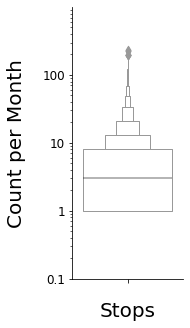

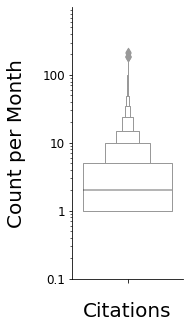

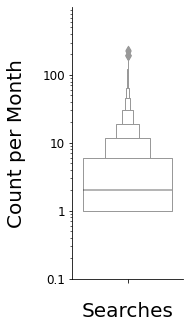

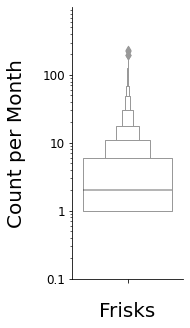

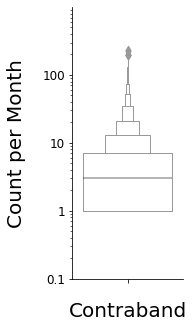

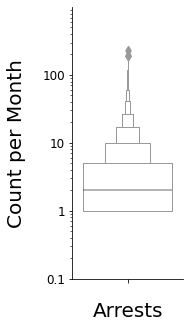

In [7]:
# Plot letter-value plots / boxen plots of the different distributions. 
# NB: These are Figure 1 in the manuscript
def boxen(df, x_label):
  f, ax = plt.subplots(figsize=(2, 5))
  sns.boxenplot(y=df, color='white')
  plt.xlabel(x_label, fontsize=20, labelpad=(16))
  plt.ylabel('Count per Month', fontsize=20, labelpad=(16))
  plt.ylim(.1, 1000)
  plt.yscale("log")
  plt.yticks(ticks=[.1, 1, 10, 100], labels=['0.1', '1', '10', '100'], fontsize=12)
  # plt.yticks(fontsize=12)
  right_side = ax.spines["right"]
  right_side.set_visible(False)
  top = ax.spines["top"]
  top.set_visible(False)
  plt.show()

boxen(offcr_stops, 'Stops')
boxen(offcr_cites, 'Citations')
boxen(offcr_search, 'Searches')
boxen(offcr_frisk, 'Frisks')
boxen(offcr_contra, 'Contraband')
boxen(offcr_arrest, 'Arrests')

# Define single-alternative matching equation

In [8]:
# Define single alternative matching equation and import packages we'll need to
# play with it.  
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def single_match(x, k, re):
  return (k*x)/(x+re)

# Fit single-alternative matching to each officer's data

In [9]:
# Function for fitting single-alternative equation
def single_matching(df, unique_identifier, df_reinforcer, reinforcer_label, 
                    fit_df_name, subset_cat=None, month=False):
  """
    Function Inputs:
    ----------
    df: Dataframe from which to subset the individual officer data. 
    unique_identifier: Dataframe column containing the individual person id. 
    df_reinforcer: The column that contains the reinforcer being tested. 
    reinforcer_label: The label to assign to the reinforcer being tested. 
    fit_df_name: Name of the fit dataframe that is saved by running this function. 
    subset_cat: Column to subsetting df for fitting across different categories.
    month: True if binning by month and year. False if binning only by year. 

    DESCRIPTION: This function fits the single-altenative matching equation 
        (Herrnstein, 1970) to behavior data binned per month for every 
        officer in this dataframe. It is designed so you can run through a loop 
        and test a variety of potential reinforcers in your data set, determine 
        which one best describes each officer's data, and save the results. 

    Returns:
    -------
    None. Pandas dataframe automatically saved after every officer. The 
    auto-saved dataframe contains:
      (1) Unique officer id number
      (2) Reinforcer label
      (3) The subset category of the data for each fit (if specified)
      (4) The estimated k parameter for the single-alternative matching equation. 
      (5) The estimated Re parameter for the single-alternative matching equation. 
      (6) The variance accounted for by the single-alternative matching equation. 
  """
  import warnings
  warnings.filterwarnings('ignore')

  # Create list of all the unique officers in the dataset
  uniq_persons = df[unique_identifier].unique()
  
  # Lists for storing data
  person_num = []
  fit_type = []
  reinforcer_type = []
  k_val = []
  re_val = []
  r2_val = []
  error_list = []

  for i in uniq_persons:
    # Subset single officer data
    person_hash = i
    person_A = df[df[unique_identifier]==i]
    person_A = person_A[person_A['time'].notna()]
    person_A = person_A.reset_index()

    # Obtain rate of behavior per month and rate of citations per month
    person_reinforcer = person_A.groupby(['year', 'month'])[df_reinforcer].sum()
    person_behavior = person_A.groupby(['year', 'month']).size()

    if len(person_behavior) > 5:
      try:
        reinforcer_per_day = person_reinforcer / 30.42  # Convert to rate per day
        behavior_per_day = person_behavior / 30.42  # Convert to rate per day

        # Fit the single-alt matching equation to the officer data
        behavior = behavior_per_day.values
        reinforcer = reinforcer_per_day.values
        c, cov = curve_fit(single_match, reinforcer, behavior) # Fit model
        preds_from_obs = single_match(reinforcer, *c)  # Make predictions based on model params
        r_2 = r2_score(behavior, preds_from_obs) # Calculate vac to see how well the model fits

        # Append data to cols
        person_num.append(person_hash)
        reinforcer_type.append(reinforcer_label)
        fit_type.append('overall')
        k_val.append(c[0])
        re_val.append(c[1])
        r2_val.append(round(r_2, 4))

        # Save data
        All_Fits = pd.DataFrame({"person_num":person_num, "reinforcer":reinforcer_type, "fit_type":fit_type, "est_k":k_val, "est_re":re_val, "vac":r2_val})
        All_Fits.to_csv('%s.csv' %fit_df_name)

        # Run the same analysis, but grouped by race
        # Calculate rate of behavior per day and rate of citations per day
        if month==True:
          person_reinforcer = person_A.groupby(['year', 'month', subset_cat])[df_reinforcer].sum().unstack()
          person_behavior = person_A.groupby(['year', 'month', subset_cat]).size().unstack()
          reinforcer_per_day = person_reinforcer / 30.42
          behavior_per_day = person_behavior / 30.42
        else:
          person_reinforcer = person_A.groupby(['year', subset_cat])[df_reinforcer].sum().unstack()
          person_behavior = person_A.groupby(['year', subset_cat]).size().unstack()
          reinforcer_per_day = person_reinforcer / 12
          behavior_per_day = person_behavior / 12
        reinforcer_per_day = reinforcer_per_day.fillna(0)
        behavior_per_day = behavior_per_day.fillna(0)

        # Loop through each race and fit the model
        cols = list(reinforcer_per_day)
        race_plot = []
        k_plot = []
        re_plot = []
        r2_plot = []

        for k in cols:
          behavior = behavior_per_day[k].values
          reinforcer = reinforcer_per_day[k].values
          param_seeds = [16, 5]
          c, cov = curve_fit(single_match, reinforcer, behavior) # Fit model
          preds_from_obs = single_match(reinforcer, *c) # Make predictions based on model params
          r_2 = r2_score(behavior, preds_from_obs) # Calculate vac to see how well the model fits

          # Append data to cols
          person_num.append(person_hash)
          reinforcer_type.append(reinforcer_label)
          fit_type.append(k)
          race_plot.append(k)
          k_val.append(c[0])
          k_plot.append(c[0])
          re_val.append(c[1])
          re_plot.append(c[1])
          r2_val.append(round(r_2, 4))
          r2_plot.append(round(r_2, 4))

        # Save data
        All_Fits = pd.DataFrame({"person_num":person_num, "reinforcer":reinforcer_type, "fit_type":fit_type, "est_k":k_val, "est_re":re_val, "vac":r2_val})
        All_Fits.to_csv('All_Fits_Citations.csv')
    
      except:
        error_list.append(i)
        err_officers = pd.DataFrame(error_list)
        err_officers.to_csv('Error_List_%s.csv' %reinforcer_label)
        All_Fits = pd.DataFrame({"person_num":person_num, "reinforcer":reinforcer_type, "fit_type":fit_type, "est_k":k_val, "est_re":re_val, "vac":r2_val})
        All_Fits.to_csv('%s.csv' %fit_df_name)

In [10]:
# Citations as putative reinforcer binned by month
single_matching(df=data, unique_identifier='officer_id_hash', 
                df_reinforcer='citation_issued', reinforcer_label='citations', 
                fit_df_name='All_Fits_Citations', subset_cat='subject_race', 
                month=True)

In [11]:
# Searches as putative reinforcers binned by year
single_matching(df=data, unique_identifier='officer_id_hash', 
                df_reinforcer='search_conducted', reinforcer_label='searches', 
                fit_df_name='All_Fits_Searches', subset_cat='subject_race')

In [12]:
# Frisk as putative reinforcers binned by year
single_matching(df=data, unique_identifier='officer_id_hash', 
                df_reinforcer='frisk_performed', reinforcer_label='frisks', 
                fit_df_name='All_Fits_Frisks', subset_cat='subject_race')

In [13]:
# Contraband as putative reinforcers binned by year
single_matching(df=data, unique_identifier='officer_id_hash', 
                df_reinforcer='contraband_found', reinforcer_label='contraband', 
                fit_df_name='All_Fits_Contraband', subset_cat='subject_race')

In [14]:
# Arrests as putative reinforcers binned by year
single_matching(df=data, unique_identifier='officer_id_hash', 
                df_reinforcer='arrest_made', reinforcer_label='arrests', 
                fit_df_name='All_Fits_Arrests', subset_cat='subject_race')

# Combine all fit dataframes into single dataframe

In [15]:
# Combine all fit dataframes into single dataframe
cite_fits = pd.read_csv('All_Fits_Citations.csv')
cite_fits = cite_fits.drop(['Unnamed: 0'], axis=1)
search_fits = pd.read_csv('All_Fits_Searches.csv')
search_fits = search_fits.drop(['Unnamed: 0'], axis=1)
frisk_fits = pd.read_csv('All_Fits_Frisks.csv')
frisk_fits = frisk_fits.drop(['Unnamed: 0'], axis=1)
contra_fits = pd.read_csv('All_Fits_Contraband.csv')
contra_fits = contra_fits.drop(['Unnamed: 0'], axis=1)
arrest_fits = pd.read_csv('All_Fits_Arrests.csv')
arrest_fits = arrest_fits.drop(['Unnamed: 0'], axis=1)

all_fits = cite_fits.append([search_fits, frisk_fits, contra_fits, arrest_fits])
all_fits.to_csv('All_Single_Alt_Matching_Fits.csv')

In [16]:
all_fits.columns = ['person_num', 'reinforcer', 'fit_type', 'est_k', 'est_re', 'vac']

# Proportion descriptions for ms

In [17]:
# Distribution vals for everything
pd.set_option('max_colwidth', 30) 
pd.set_option('max_rows', len(all_fits))
all_fits.groupby(['fit_type', 'reinforcer']).describe()

est_k                ...       vac        
                                    count          mean  ...       75%     max
fit_type               reinforcer                        ...                  
asian/pacific islander arrests     1112.0  9.394063e+04  ... -0.200000  1.0000
                       contraband   556.0  1.054132e+00  ... -0.216200  1.0000
                       frisks       556.0  3.298623e+04  ... -0.190500  1.0000
                       searches     556.0  1.933104e+07  ...  1.000000  1.0000
black                  arrests     1881.0  1.487129e+07  ...  0.657900  1.0000
                       contraband   940.0  3.202294e+06  ...  0.059275  1.0000
                       frisks       940.0  1.349832e+07  ...  0.777800  1.0000
                       searches     940.0  2.324417e+08  ...  1.000000  1.0000
hispanic               arrests      856.0  7.167232e+00  ... -0.142900  1.0000
                       contraband   428.0  7.101213e+00  ... -0.166700  1.0000
                       frisks       428.0  3.930504e+03  ... -0.142900  1.0000
                       searches     428.0  1.257053e+07  ...  1.000000  1.0000
other                  arrests     1226.0  1.840145e+04  ... -0.222200  1.0000
                       contraband   613.0  1.035824e+00  ... -0.250000  1.0000
                       frisks       613.0  2.182474e+05  ... -0.200000  1.0000
                       searches     613.0  2.558939e+07  ...  1.000000  1.0000
overall                arrests     2002.0  1.342211e+05  ... -0.177100  0.9186
                       contraband  1001.0  2.536111e+04  ... -0.919600  0.5796
                       frisks      1001.0  8.925063e+04  ... -0.381300  0.8747
                       searches    1001.0  1.112817e+07  ...  0.992100  1.0000
unknown                arrests      784.0  2.914212e+05  ... -0.142900  1.0000
                       contraband   392.0  1.369705e+00  ... -0.166700  1.0000
                       frisks       392.0  2.147842e+04  ... -0.126575  1.0000
                       searches     392.0  2.754285e+07  ...  1.000000  1.0000
white                  arrests     1933.0  1.007788e+07  ...  0.620600  1.0000
                       contraband   966.0  1.762237e+06  ... -0.550600  1.0000
                       frisks       966.0  7.120991e+06  ...  0.447175  1.0000
                       searches     966.0  1.648146e+08  ...  1.000000  1.0000

[28 rows x 24 columns]

In [18]:
# Print the proportion of officers whose databehavior was described by the 
# single-alternative matching equation with vac greater than 90%
print((round((cite_fits['vac'].ge(0.9).sum())/len(cite_fits), 5)), "= Citation Proportion >90%")
print((round((search_fits['vac'].ge(0.9).sum())/len(search_fits), 5)), "= Search Proportion >90%")
print((round((frisk_fits['vac'].ge(0.9).sum())/len(frisk_fits), 5)), "= Frisk Proportion >90%")
print((round((contra_fits['vac'].ge(0.9).sum())/len(contra_fits), 5)), "= Contraband Found Proportion >90%")
print((round((arrest_fits['vac'].ge(0.9).sum())/len(arrest_fits), 5)), "= Arrest Proportion >90%")

0.0539 = Citation Proportion >90%
0.90359 = Search Proportion >90%
0.06311 = Frisk Proportion >90%
0.01797 = Contraband Found Proportion >90%
0.05392 = Arrest Proportion >90%


In [19]:
# Print the proportion of officers whose databehavior was described by the 
# single-alternative matching equation with vac greater than 80%
print((round((cite_fits['vac'].ge(0.8).sum())/len(cite_fits), 5)), "= Citation Proportion >80%")
print((round((search_fits['vac'].ge(0.8).sum())/len(search_fits), 5)), "= Search Proportion >80%")
print((round((frisk_fits['vac'].ge(0.8).sum())/len(frisk_fits), 5)), "= Frisk Proportion >80%")
print((round((contra_fits['vac'].ge(0.8).sum())/len(contra_fits), 5)), "= Contraband Found Proportion >80%")
print((round((arrest_fits['vac'].ge(0.8).sum())/len(arrest_fits), 5)), "= Arrest Proportion >80%")

0.08269 = Citation Proportion >80%
0.93301 = Search Proportion >80%
0.08926 = Frisk Proportion >80%
0.0288 = Contraband Found Proportion >80%
0.08272 = Arrest Proportion >80%


In [20]:
# Print the number of officers for whom:
# VAC > 90%
print('VAC > 90%')
print(cite_fits['vac'].ge(0.9).sum(), "= Citation Count")
print(search_fits['vac'].ge(0.9).sum(), "= Search Count")
print(frisk_fits['vac'].ge(0.9).sum(), "= Frisk Count")
print(contra_fits['vac'].ge(0.9).sum(), "= Contraband Count")
print(arrest_fits['vac'].ge(0.9).sum(), "= Arrest Count")

# VAC > 80%
print('\nVAC > 80%')
print(cite_fits['vac'].ge(0.8).sum(), "= Citation Count")
print(search_fits['vac'].ge(0.8).sum(), "= Search Count")
print(frisk_fits['vac'].ge(0.8).sum(), "= Frisk Count")
print(contra_fits['vac'].ge(0.8).sum(), "= Contraband Count")
print(arrest_fits['vac'].ge(0.8).sum(), "= Arrest Count")

VAC > 90%
264 = Citation Count
4424 = Search Count
309 = Frisk Count
88 = Contraband Count
264 = Arrest Count

VAC > 80%
405 = Citation Count
4568 = Search Count
437 = Frisk Count
141 = Contraband Count
405 = Arrest Count


In [21]:
# Create list of officers for whom vac was > 90% using Eq. 1
def offcrs_90(df):
  temp_list = []
  reinf = []
  for i in range(len(df)):
    if df['vac'][i]>=0.90:
      if df['person_num'][i] in temp_list:
        continue
      else:
        temp_list.append(df['person_num'][i])
        reinf.append(df['reinforcer'][i])
  return pd.DataFrame(list(zip(temp_list, reinf)), columns=['person_num', 'reinforcer'])

cites_offcr = offcrs_90(cite_fits)
search_offcr = offcrs_90(search_fits)
frisk_offcr = offcrs_90(frisk_fits)
contra_offcr = offcrs_90(contra_fits)
arrest_offcr = offcrs_90(arrest_fits)

# Combine all officer dfs where VAC was .90 or greater
all_offcr90s = cites_offcr.append(search_offcr)
all_offcr90s = all_offcr90s.append(frisk_offcr)
all_offcr90s = all_offcr90s.append(contra_offcr)
all_offcr90s = all_offcr90s.append(arrest_offcr)

# Show value counts for all_offcr90s df
print("Unique Officers with VAC > 0.90 = %s" %len(all_offcr90s['person_num'].unique()))
offcr90_val_counts = pd.DataFrame(all_offcr90s.value_counts(), columns=['count'])
offcr90_val_counts['count'].value_counts()

Unique Officers with VAC > 0.90 = 975


1    1284
2     194
Name: count, dtype: int64

In [22]:
# Combine all officer dfs where VAC was .90 or greater
all_offcr90s = cites_offcr.append(search_offcr)
all_offcr90s = all_offcr90s.append(frisk_offcr)
all_offcr90s = all_offcr90s.append(contra_offcr)
all_offcr90s = all_offcr90s.append(arrest_offcr)

In [23]:
print("Unique Officers with VAC > 90 = %s" %len(all_offcr90s['person_num'].unique()))
offcr90_val_counts = pd.DataFrame(all_offcr90s.value_counts(), columns=['count'])
offcr90_val_counts['count'].unique()

Unique Officers with VAC > 90 = 975


array([2, 1])